In [4]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
from os.path import dirname, join as pjoin
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.playback import play

Duration = 3.7877551020408164s


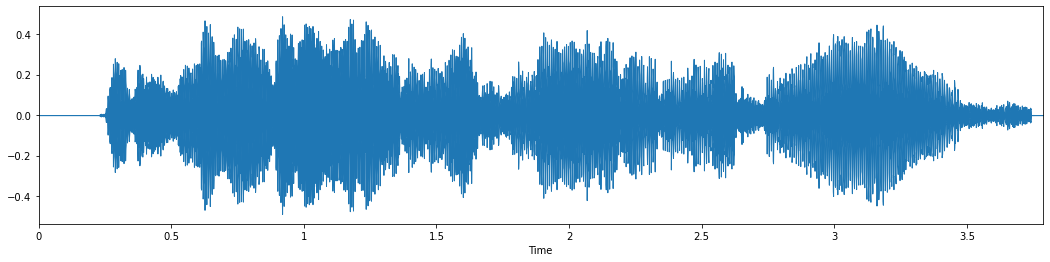

In [6]:
wav_fname = "../DataBase/بسم الله الرحمن الرحيم .. صوت (128  kbps) (shabakngy.com).wav"
# sr,data=scipy.io.wavfile.read(wav_fname)
data,sr=librosa.load(wav_fname)
plt.figure(figsize=(18,4))
librosa.display.waveplot(data,sr)
length = data.shape[0] / sr
print(f"Duration = {length}s")
# print(f"number of channels = {data.shape[1]}")
# ipd.Audio(wav_fname,autoplay=True)  
# play(AudioSegment.from_wav(wav_fname))

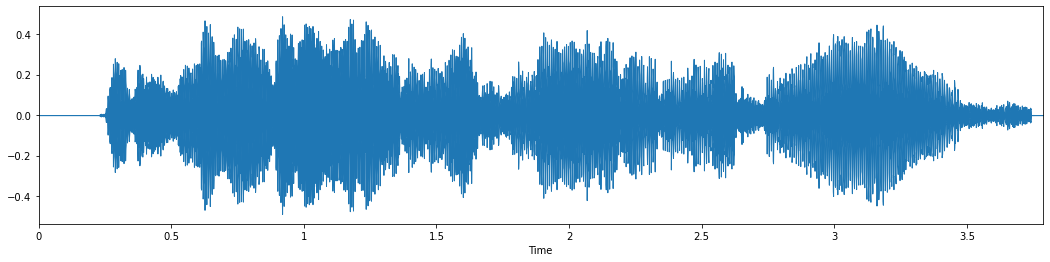

In [7]:
emphasized_signal=numpy.append(data[0],data[1:]-0.97*data[:1])
data,sr=librosa.load(wav_fname)
plt.figure(figsize=(18,4))
librosa.display.waveplot(emphasized_signal,sr)

In [8]:
# frame_size=int(round(0.025*sr)) 
# frame_strid=int(round(0.01*sr))
# num_frames=int(numpy.ceil(float(numpy.abs(len(emphasized_signal)-frame_size))/frame_strid))
# new_signal_length=num_frames*frame_strid+frame_size # result signal of concatinating frames
# z=numpy.zeros(new_signal_length-len(data)) # zeros added to frames
# pad_signal=numpy.append(emphasized_signal,z) # 
# print(len(data))
# print(len(emphasized_signal))
# print(num_frames)
# print(new_signal_length)
# print(len(pad_signal))


83520
83520
378
83711
[[    0     1     2 ...   548   549   550]
 [  220   221   222 ...   768   769   770]
 [  440   441   442 ...   988   989   990]
 ...
 [82500 82501 82502 ... 83048 83049 83050]
 [82720 82721 82722 ... 83268 83269 83270]
 [82940 82941 82942 ... 83488 83489 83490]]
(378, 551)


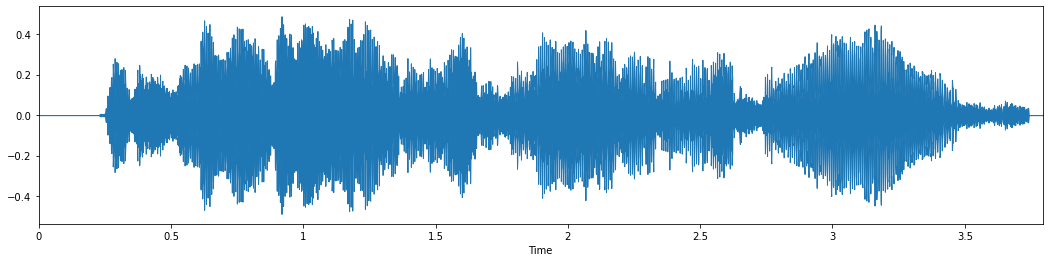

In [9]:
# Split the signal into short-time frames
frame_size = 0.025
frame_stride = 0.01
# Convert from seconds to samples
frame_length, frame_step = frame_size * sr, frame_stride * sr
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
# Make sure that we have at least 1 frame
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))
pad_signal_length = num_frames * frame_step + frame_length 
z = numpy.zeros((pad_signal_length - signal_length)) #Return a new array of given shape and type, filled with zeros.
pad_signal = numpy.append(emphasized_signal, z)
indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0,num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]
print(len(data))
print(len(emphasized_signal))
print(num_frames)
print(pad_signal_length)
#print(len(z)," => ",z)
#print(len(pad_signal),"=>",pad_signal)
print(indices)
print(frames.shape)
plt.figure(figsize=(18,4))
librosa.display.waveplot(pad_signal,sr)

In [10]:
#Windowing
frames *= numpy.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation
frames.shape

(378, 551)

In [11]:
#Fourier-Transform and Power Spectrum
NFFT = 512 # or 256
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [12]:
#Filter Banks
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sr / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sr)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

In [13]:
#Mel-frequency Cepstral Coefficients (MFCCs)
num_ceps = 12
cep_lifter = 22 #refers to the dimensionality of the MFCC vector in the original formulation.

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift

C:\Users\dell\anaconda3\lib\site-packages\librosa\util\utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


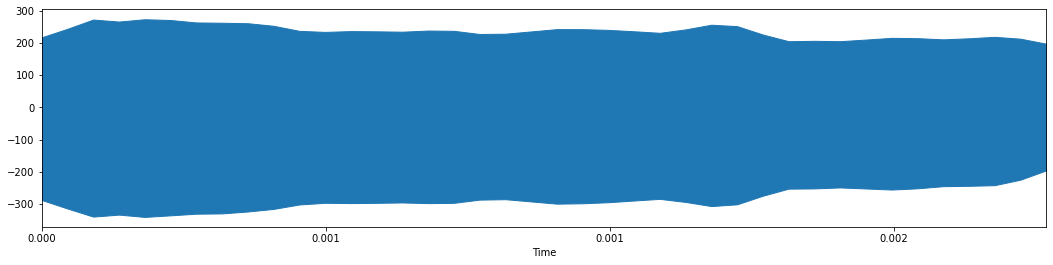

In [14]:
# Mean Normalization
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)
plt.figure(figsize=(18,4))
librosa.display.waveplot(filter_banks,sr)